<a href="https://colab.research.google.com/github/MahaleVivek/HandsOn-LLMs/blob/modules/modules/Ch12_finetuning_generation_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Three LLM Training Steps: Pretraining, Supervised Fine-Tuning, and Preference Tuning

1. Language modeling

    The first step in creating a high-quality LLM is to pretrain it on one or more massive text datasets. During training, it attempts to predict the next token to accurately learn linguistic and semantic representations found in the text. As we saw before in Chapters 3 and 11, this is called language modeling and is a self-supervised method.

    This produces a base model, also commonly referred to as a pretrained or foundation model. Base models are a key artifact of the training process but are harder for the end user to deal with. This is why the next step is important.

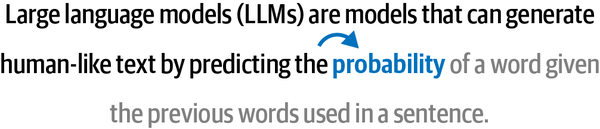

2. Fine-tuning 1 (supervised fine-tuning)

    LLMs are more useful if they respond well to instructions and try to follow them. When humans ask the model to write an article, they expect the model to generate the article and not list other instructions for example (which is what a base model might do).

    With supervised fine-tuning (SFT), we can adapt the base model to follow instructions. During this fine-tuning process, the parameters of the base model are updated to be more in line with our target task, like following instructions. Like a pretrained model, it is trained using next-token prediction but instead of only predicting the next token, it does so based on a user input

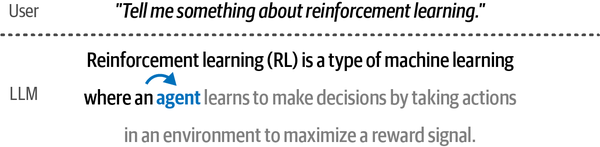

SFT can also be used for other tasks, like classification, but is often used to go from a base generative model to an instruction (or chat) generative model.

3. Fine-tuning 2 (preference tuning)

    The final step further improves the quality of the model and makes it more aligned with the expected behavior of AI safety or human preferences. This is called preference tuning. Preference tuning is a form of fine-tuning and, as the name implies, aligns the output of the model to our preferences, which are defined by the data that we give it. Like SFT, it can improve upon the original model but has the added benefit of distilling preference of output in its training process. These three steps are illustrated in Figure 12-3 and demonstrate the process of starting from an untrained architecture and ending with a preference-tuned LLM.

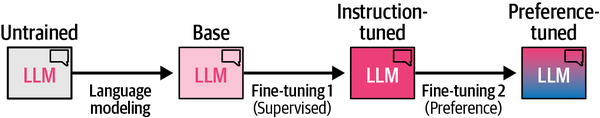

### Supervised Fine-Tuning (SFT)

Full Fine-Tuning

The most common fine-tuning process is full fine-tuning. Like pretraining an LLM, this process involves updating all parameters of a model to be in line with your target task. The main difference is that we now use a smaller but labeled dataset whereas the pretraining process was done on a large dataset without any labels

**Parameter-Efficient Fine-Tuning (PEFT)**

Updating all parameters of a model has a large potential of increasing its performance but comes with several disadvantages.
1. It is costly to train,
2. has slow training times, and
3. requires significant storage.

To resolve these issues, attention has been given to parameter-efficient fine-tuning (PEFT) alternatives that focus on fine-tuning pretrained models at higher computational efficiency.

**Adapters**

>**Adapters** are a core component of many PEFT-based techniques. The method proposes a set of additional modular components inside the Transformer that can be fine-tuned to improve the model’s performance on a specific task without having to fine-tune all the model weights. This saves a lot of time and compute.

**Low-Rank Adaptation (LoRA)**

>As an alternative to adapters, low-rank adaptation (LoRA) was introduced and is at the time of writing is a widely used and effective technique for PEFT. LoRA is a technique that (like adapters) only requires updating a small set of parameters. it creates a small subset of the base model to fine-tune instead of adding layers to the model.4


**Compressing the model for (more) efficient training**

>We can make LoRA even more efficient by reducing the memory requirements of the model’s original weights before projecting them into smaller matrices. The weights of an LLM are numeric values with a given precision, which can be expressed by the number of bits like float64 or float32. if we lower the amount of bits to represent a value, we get a less accurate result. However, if we lower the number of bits we also lower the memory requirements of that model.

* With quantization, we aim to lower the number of bits while still accurately
representing the original weight values. However, when directly mapping higher precision values to lower precision values, multiple higher precision values might end up being represented by the same lower precision values.


* Instead, the authors of QLoRA, a quantized version of LoRA, found a way to go from a higher number of bits to a lower value and vice versa without differentiating too much from the original weights.


* They used blockwise quantization to map certain blocks of higher precision values to lower precision values. Instead of directly mapping higher precision to lower precision values, additional blocks are created that allow for quantizing similar weights. this results in values that can be accurately represented with lower precision.


Combined with the blockwise quantization, this normalization procedure allows for accurate representation of high precision values by low precision values with only a small decrease in the performance of the LLM. As a result, we can go from a 16-bit float representation to a measly 4-bit normalized float representation. A 4-bit representation significantly reduces the memory requirements of the LLM during training. Note that the quantization of LLMs in general is also helpful for inference as quantized LLMs are smaller in size and therefore require less VRAM.



---



### Instruction Tuning with QLoRA

In [13]:
!pip install datasets -q #bitsandbytes

In [15]:
from transformers import AutoTokenizer
from datasets import load_dataset

# Load a tokenizer to use its chat template
template_tokenizer = AutoTokenizer.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
)

In [16]:
def format_prompt(example):
    """Format the prompt to using the <|user|> template TinyLLama is using"""

    # Format answers
    chat = example["messages"]
    prompt = template_tokenizer.apply_chat_template(chat, tokenize=False)

    return {"text": prompt}

# Load and format the data using the template TinyLLama is using
dataset = (
    load_dataset("HuggingFaceH4/ultrachat_200k", split="test_sft")
      .shuffle(seed=42)
      .select(range(3_000))
)
dataset = dataset.map(format_prompt)

In [4]:
# We select a subset of 3,000 documents to reduce the training time, but you can increase this value to get more accurate results.

In [5]:
# Example of formatted prompt
print(dataset["text"][2576])

<|user|>
Given the text: Knock, knock. Who’s there? Hike.
Can you continue the joke based on the given text material "Knock, knock. Who’s there? Hike"?</s>
<|assistant|>
Sure! Knock, knock. Who's there? Hike. Hike who? Hike up your pants, it's cold outside!</s>
<|user|>
Can you tell me another knock-knock joke based on the same text material "Knock, knock. Who's there? Hike"?</s>
<|assistant|>
Of course! Knock, knock. Who's there? Hike. Hike who? Hike your way over here and let's go for a walk!</s>



### Model Quantization

Now that we have our data, we can start loading in our model. This is where we apply the Q in QLoRA, namely quantization. We use the bitsandbytes package to compress the pretrained model to a 4-bit representation.

In BitsAndBytesConfig, you can define the quantization scheme. We follow the steps used in the original QLoRA paper and load the model in 4-bit (load_in_4bit) with a normalized float representation (bnb_4bit_quant_type) and double quantization (bnb_4bit_use_double_quant):

In [8]:
!pip install bitsandbytes -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 886.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00


In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [2]:
# 4-bit quantization configuration - Q in QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Use 4-bit precision model loading
    bnb_4bit_quant_type="nf4",  # Quantization type
    bnb_4bit_compute_dtype="float16",  # Compute dtype
    bnb_4bit_use_double_quant=True,  # Apply nested quantization
)

In [3]:
!pip install -U bitsandbytes

In [4]:
# Load the model to train on the GPU
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",

    # Leave this out for regular SFT
    quantization_config=bnb_config,
)
model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [5]:
# restart the session if giving ImportError

In [6]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = "<PAD>"
tokenizer.padding_side = "left"

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

This quantization procedure allows us to decrease the size of the original model while retaining most of the original weights’ precision. Loading the model now only uses ~1 GB VRAM compared to the ~4 GB of VRAM it would need without quantization. Note that during fine-tuning, more VRAM will be necessary so it does not cap out on the ~1 GB VRAM needed to load the model.

#### LoRA Configuration

In [7]:
# we will need to define our LoRA configuration using the peft library, which represents hyperparameters of the fine-tuning process:

In [8]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# Prepare LoRA Configuration
peft_config = LoraConfig(
    lora_alpha=32,  # LoRA Scaling
    lora_dropout=0.1,  # Dropout for LoRA Layers
    r=64,  # Rank
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=  # Layers to target
     ["k_proj", "gate_proj", "v_proj", "up_proj", "q_proj", "o_proj", "down_proj"]
)

# Prepare model for training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

There are several parameters worth mentioning:

1. r
  > This is the rank of the compressed matrices Increasing this value will also increase the sizes of compressed matrices leading to less compression and thereby improved representative power. Values typically range between 4 and 64.
2. lora_alpha
  >  Controls the amount of change that is added to the original weights. In essence, it balances the knowledge of the original model with that of the new task. A rule of thumb is to choose a value twice the size of r.
3. target_modules
  > Controls which layers to target. The LoRA procedure can choose to ignore specific layers, like specific projection layers. This can speed up training but reduce performance and vice versa.

Note: This example demonstrates an efficient form of fine-tuning your model. If you want to perform full fine-tuning instead, you can remove the quantization_config parameter when loading the model and skip the creation of peft_config. By removing those, we would go from “Instruction tuning with QLoRA” to “full instruction tuning.”

### Training Configuration


In [9]:
from transformers import TrainingArguments

output_dir = "./results"

# Training arguments
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    num_train_epochs=1,
    logging_steps=10,
    fp16=True,
    gradient_checkpointing=True
)

There are several parameters worth mentioning:

1. num_train_epochs
  >  The total number of training rounds. Higher values tend to degrade performance so we generally like to keep this low.
2. learning_rate
  >  Determines the step size at each iteration of weight updates. The authors of QLoRA found that higher learning rates work better for larger models (>33B parameters).
3. lr_scheduler_type
  >  A cosine-based scheduler to adjust the learning rate dynamically. It will linearly increase the learning rate, starting from zero, until it reaches the set value. After that, the learning rate is decayed following the values of a cosine function.
4. optim
  >  The paged optimizers used in the original QLoRA paper.

Optimizing these parameters is a difficult task and there are no set guidelines for doing so. It requires experimentation to figure out what works best for specific datasets, model sizes, and target tasks.

Note: Although this section describes instruction tuning, we could also use QLoRA to fine-tune an instruction model. For instance, we could fine-tune a chat model to generate specific SQL code or to create JSON output that adheres to a specific format. As long as you have the data available (with appropriate query-response items), QLoRA is a great technique for nudging an existing chat model to be more appropriate for your use case.

### Training

In [10]:
%%capture

!pip install -q accelerate==0.31.0 peft==0.11.1 bitsandbytes==0.43.1 transformers==4.41.2 trl==0.9.4 sentencepiece==0.2.0

In [17]:
from trl import SFTTrainer

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    max_seq_length=512,

    # Leave this out for regular SFT
    peft_config=peft_config,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:2058: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  )
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in t

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:397: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [18]:
# Train model
trainer.train()

# Save QLoRA weights
trainer.model.save_pretrained("TinyLlama-1.1B-qlora")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vivekmahale9853 (vivekmahale9853-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,1.670700
20,1.476000
30,1.451000
40,1.487800
50,1.477900
60,1.390500
70,1.494700
80,1.450100
90,1.427500
100,1.404300


During training the loss will be printed every 10 steps according to the logging_steps parameter.

### Merge Weights

After we have trained our QLoRA weights, we still need to combine them with the original weights to use them. We reload the model in 16 bits, instead of the quantized 4 bits, to merge the weights. Although the tokenizer was not updated during training, we save it to the same folder as the model for easier access:

In [19]:
from peft import AutoPeftModelForCausalLM

model = AutoPeftModelForCausalLM.from_pretrained(
    "TinyLlama-1.1B-qlora",
    low_cpu_mem_usage=True,
    device_map="auto",
)

# Merge LoRA and base model
merged_model = model.merge_and_unload()

In [20]:
from transformers import pipeline

# Use our predefined prompt template
prompt = """<|user|>
Tell me something about Large Language Models.</s>
<|assistant|>
"""

In [21]:
# Run our instruction-tuned model
pipe = pipeline(task="text-generation", model=merged_model, tokenizer=tokenizer)
print(pipe(prompt)[0]["generated_text"])

<|user|>
Tell me something about Large Language Models.</s>
<|assistant|>
Large Language Models (LLMs) are a type of artificial intelligence (AI) that can generate human-like language. They are trained on large amounts of data, including text, audio, and video, and are capable of generating complex sentences and phrases. LLMs can be used in a variety of applications, including natural language processing (NLP), machine translation, and chatbots.


The aggregate output shows that the model now closely follows our instructions, which is not possible with the base model.

## Evaluating Generative Models


* Evaluating generative models poses a significant challenge. Generative models
are used across many diverse use cases, making it a challenge to rely on a singular metric for judgment. Unlike more specialized models, a generative model’s ability to solve mathematical questions does not guarantee success in solving coding questions.

* At the same time, evaluating these models is vital, particularly in production settings where consistency is important. Given their probabilistic nature, generative models do not necessarily generate consistent outputs; there is a need for robust evaluation.

#### Word-Level Metrics

One common metrics category for comparing generative models is word-level evaluation. These classic techniques compare a reference dataset with the generated tokens on a token(set) level. Common word-level metrics include perplexity,8 ROUGE,9 BLEU,10 and BERTScore.11

Of note is perplexity, which measures how well a language model predicts a text. Given input text, the model predicts how likely the next token is. With perplexity, we assume a model performs better if it gives the next token a high probability. In other words, the models should not be “perplexed” when presented with a well-written document.

#### Benchmarks

 common method for evaluating generative models on language generation and understanding tasks is on well-known and public benchmarks, such as MMLU,12 GLUE,13 TruthfulQA,14 GSM8k,15 and HellaSwag.16 These benchmarks give us information about basic language understanding but also complex analytical answering, like math problems.

Aside from natural language tasks, some models specialize in other domains, like programming. These models tend to be evaluated on different benchmarks, such as HumanEval,17 which consists of challenging programming tasks for the model to solve.

1. MMLU 	The Massive Multitask Language Understanding (MMLU) benchmark tests the model on 57 different tasks, including classification, question answering, and sentiment analysis. 	https://oreil.ly/nrG_g
2. GLUE 	The General Language Understanding Evaluation (GLUE) benchmark consists of language understanding tasks covering a wide degree of difficulty. 	https://oreil.ly/LV_fb
3. TruthfulQA 	TruthfulQA measures the truthfulness of a model’s generated text. 	https://oreil.ly/i2Brj
4. GSM8k 	The GSM8k dataset contains grade-school math word problems. It is linguistically diverse and created by human problem writers. 	https://oreil.ly/oOBXY
5. HellaSwag 	HellaSwag is a challenge dataset for evaluating common-sense inference. It consists of multiple-choice questions that the model needs to answer. It can select one of four answer choices for each question. 	https://oreil.ly/aDvBP
6. HumanEval 	The HumanEval benchmark is used for evaluating generated code based on 164 programming problems.

Note: Benchmarks are a great way to get a basic understanding on how well a model performs on a wide variety of tasks. A downside to public benchmarks is that models can be overfitted to these benchmarks to generate the best responses. Moreover, these are still broad benchmarks and might not cover very specific use cases. Lastly, another downside is that some benchmarks require strong GPUs with a long running time (over hours) to compute, which makes iteration difficult.

### Leaderboards

With so many different benchmarks, it is hard to choose which benchmark best suits your model. Whenever a model is released, you will often see it evaluated on several benchmarks to showcase how it performs across the board.

As such, leaderboards were developed containing multiple benchmarks. A common leaderboard is the Open LLM Leaderboard, which, at the time of writing, includes six benchmarks, including HellaSwag, MMLU, TruthfulQA, and GSM8k. Models that top the leaderboard, assuming they were not overfitted on the data, are generally regarded as the “best” model. However, since these leaderboards often contain publicly available benchmarks, there is a risk of overfitting on the leaderboard.



---


## Human Evaluation

* Although benchmarks are important, the gold standard of evaluation is generally considered to be human evaluation. Even if an LLM scores well on broad benchmarks, it still might not score well on domain-specific tasks. Moreover, benchmarks do not fully capture human preference and all methods discussed before are merely proxies for that.

* A great example of a human-based evaluation technique is the Chatbot Arena.19 When you go to this leaderboard you are shown two (anonymous) LLMs you can interact with. Any question or prompt you ask will be sent to both models and you will receive their output. Then, you can decide which output you prefer. This process allows for the community to vote on which models they prefer without knowing which ones are presented. Only after you vote do you see which model generated which text.

* At the time of writing, this method has generated over 800,000+ human votes that were used to compute a leaderboard. These votes are used to calculate the relative skill level of LLMs based on their win rates. For instance, if a low-ranked LLM beats a high-ranked LLM, its ranking changes significantly. In chess, this is referred to as the Elo rating system.

* This methodology therefore uses crowdsourced votes, which helps us understand the quality of the LLM. However, it is still the aggregated opinion of a wide variety of users, which might not relate to your use case.

---

As a result, there is no one perfect method of evaluating LLMs. All mentioned methodologies and benchmarks provide an important, although limited evaluation perspective. Our advice is to evaluate your LLM based on the intended use case. For coding, HumanEval would be more logical than GSM8k.

But most importantly, we believe that you are the best evaluator. Human evaluation remains the gold standard because it is up to you to decide whether the LLM works for your intended use case. As with the examples in this chapter, we highly advise that you also try these models and perhaps develop some questions yourself. For example, the authors of this book are Arabic (Jay Alammar) and Dutch (Maarten Grootendorst), and we often ask questions in our native language when approached with new models.

One final note on this topic is a quote we hold dear:

    When a measure becomes a target, it ceases to be a good measure.

    Goodhart’s Law20

In the context of LLMs, when using a specific benchmark, we tend to optimize for that benchmark regardless of the consequences. For instance, if we focus purely on optimizing for generating grammatically correct sentences, the model could learn to only output one sentence: “This is a sentence.” It is grammatically correct but tells you nothing about its language understanding capabilities. Thus, the model may excel at a specific benchmark but potentially at the expense of other useful capabilities.

### Preference-Tuning / Alignment / RLHF

Although our model can now follow instructions, we can further improve its behavior by a final training phase that aligns it to how we expect it to behave in different scenarios. For instance, when asked “What is an LLM?” we might prefer an elaborate answer that describes the internals of an LLM compared to the answer “It is a large language model” without further explanations. How exactly do we align our (human) preference for one answer over the other with the output of an LLM?

1. To start with, recall that an LLM takes a prompt and outputs a generation
2. We can ask a person (preference evaluator) to evaluate the quality of that model generation. Say they assign it a certain score
3. a preference tuning step updating the model based on that score:

  * If the score is high, the model is updated to encourage it to generate more like this type of generation.

  * If the score is low, the model is updated to discourage such generations.

As always, we need many training examples. So can we automate the preference evaluation? Yes, we can by training a different model called a reward model.

### Preference Tuning with DPO

When we use the Hugging Face stack, preference tuning is eerily similar to the instruction tuning we covered before with some slight differences. We will still be using TinyLlama but this time an instruction-tuned version that was first trained using full fine-tuning and then further aligned with DPO. Compared to our initial instruction-tuned model, this LLM was trained on much larger datasets.

#### Templating Alignment Data

In [25]:
from datasets import load_dataset

def format_prompt(example):
    """Format the prompt to using the <|user|> template TinyLLama is using"""

    # Format answers
    system = "<|system|>\n" + example["system"] + "</s>\n"
    prompt = "<|user|>\n" + example["input"] + "</s>\n<|assistant|>\n"
    chosen = example["chosen"] + "</s>\n"
    rejected = example["rejected"] + "</s>\n"

    return {
        "prompt": system + prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

In [26]:
# Apply formatting to the dataset and select relatively short answers
dpo_dataset = load_dataset(
    "argilla/distilabel-intel-orca-dpo-pairs", split="train"
)
dpo_dataset = dpo_dataset.filter(
    lambda r:
        r["status"] != "tie" and
        r["chosen_score"] >= 8 and
        not r["in_gsm8k_train"]
)
dpo_dataset = dpo_dataset.map(
    format_prompt,  remove_columns=dpo_dataset.column_names
)

README.md:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/79.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12859 [00:00<?, ? examples/s]

Map:   0%|          | 0/5922 [00:00<?, ? examples/s]

In [27]:
dpo_dataset

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 5922
})

#### Model Quantization

We load our base model and load it with the LoRA we created previously. As before, we quantize the model to reduce the necessary VRAM for training:

In [28]:
from peft import AutoPeftModelForCausalLM
from transformers import BitsAndBytesConfig, AutoTokenizer

In [34]:
!pip install bitsandbytes==0.43.2 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 9.2 MB/s eta 0:00:00


In [35]:
# 4-bit quantization configuration - Q in QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Use 4-bit precision model loading
    bnb_4bit_quant_type="nf4",  # Quantization type
    bnb_4bit_compute_dtype="float16",  # Compute dtype
    bnb_4bit_use_double_quant=True,  # Apply nested quantization
)

# Merge LoRA and base model
model = AutoPeftModelForCausalLM.from_pretrained(
    "TinyLlama-1.1B-qlora",
    low_cpu_mem_usage=True,
    device_map="auto",
    quantization_config=bnb_config,
)
merged_model = model.merge_and_unload()

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:355: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  )


In [36]:
# Load LLaMA tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = "<PAD>"
tokenizer.padding_side = "left"

In [37]:
# Next, we use the same LoRA configuration as before to perform the DPO training:

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# Prepare LoRA configuration
peft_config = LoraConfig(
    lora_alpha=32,  # LoRA Scaling
    lora_dropout=0.1,  # Dropout for LoRA Layers
    r=64,  # Rank
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=  # Layers to target
     ["k_proj", "gate_proj", "v_proj", "up_proj", "q_proj", "o_proj", "down_proj"]
)

In [38]:
# prepare model for training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

### Training Configuration

For the sake of simplicity, we will use the same training arguments as we did before with one difference. Instead of running for a single epoch (which can take up to two hours), we run for 200 steps instead for illustration purposes. Moreover, we added the warmup_ratio parameter, which increases the learning rate from 0 to the learning_rate value we set for the first 10% of steps. By maintaining a small learning rate at the start (i.e., warmup period), we allow the model to adjust to the data before applying larger learning rates, therefore avoiding harmful divergence:

In [39]:
from trl import DPOConfig

output_dir = "./results"

# Training arguments
training_arguments = DPOConfig(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    learning_rate=1e-5,
    lr_scheduler_type="cosine",
    max_steps=200,
    logging_steps=10,
    fp16=True,
    gradient_checkpointing=True,
    warmup_ratio=0.1
)

### Training

Now that we have prepared all our models and parameters, we can start fine-tuning our model:

In [40]:
from trl import DPOTrainer

# Create DPO trainer
dpo_trainer = DPOTrainer(
    model,
    args=training_arguments,
    train_dataset=dpo_dataset,
    tokenizer=tokenizer,
    peft_config=peft_config,
    beta=0.1,
    max_prompt_length=512,
    max_length=512,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_prompt_length, max_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in DPOTrainer, please use the DPOConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:355: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  )
/usr/local/lib/python3.11/dist-packages/trl/trainer/dpo_trainer.py:358: UserWarning: You passed `max_length` to the DPOTrainer, the value you passed will override the one in the `DPOConfig`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/dpo_trainer.py:371: UserWarning: You passed `max_prompt_length` to the DPOTrainer, the value you passed will override the one in the `DPOConfig`.
  warnings.warn(
/usr/local/lib/python3.11/dist-pack

Map:   0%|          | 0/5922 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [41]:
# Fine-tune model with DPO
dpo_trainer.train()

# Save adapter
dpo_trainer.model.save_pretrained("TinyLlama-1.1B-dpo-qlora")

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,0.692200
20,0.677900
30,0.645300
40,0.607800
50,0.597100
60,0.617200
70,0.594000
80,0.532200
90,0.558700
100,0.636900


In [42]:
# We have created a second adapter. To merge both adapters, we iteratively merge the adapters with the base model:

from peft import PeftModel

# Merge LoRA and base model
model = AutoPeftModelForCausalLM.from_pretrained(
    "TinyLlama-1.1B-qlora",
    low_cpu_mem_usage=True,
    device_map="auto",
)
sft_model = model.merge_and_unload()

In [43]:
# Merge DPO LoRA and SFT model
dpo_model = PeftModel.from_pretrained(
    sft_model,
    "TinyLlama-1.1B-dpo-qlora",
    device_map="auto",
)
dpo_model = dpo_model.merge_and_unload()

/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight', 'base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight', 'base_model.model.model.layers.0.mlp.gate_proj.lora_B.default.weight', 'base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight', 'base_model.model.model.layers.0.mlp.up_proj.lora_B.default.we

In [44]:
dpo_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

This combination of SFT+DPO is a great way to first fine-tune your model to perform basic chatting and then align its answers with human preference. However, it does come at a cost since we need to perform two training loops and potentially tweak the parameters in two processes.

Since the release of DPO, new methods of aligning preferences have been developed. Of note is Odds Ratio Preference Optimization (ORPO), a process that combines SFT and DPO into a single training process.23 It removes the need to perform two separate training loops, further simplifying the training process while allowing for the use of QLoRA.
